Data sample:
     ENGINESIZE  FUELCONSUMPTION_COMB  CO2EMISSIONS
108         4.4                  12.7           292
428         1.6                   9.5           218
709         2.0                   7.2           166
410         1.6                   8.1           186
513         2.0                   9.6           221

Dataset shape: (1067, 3)


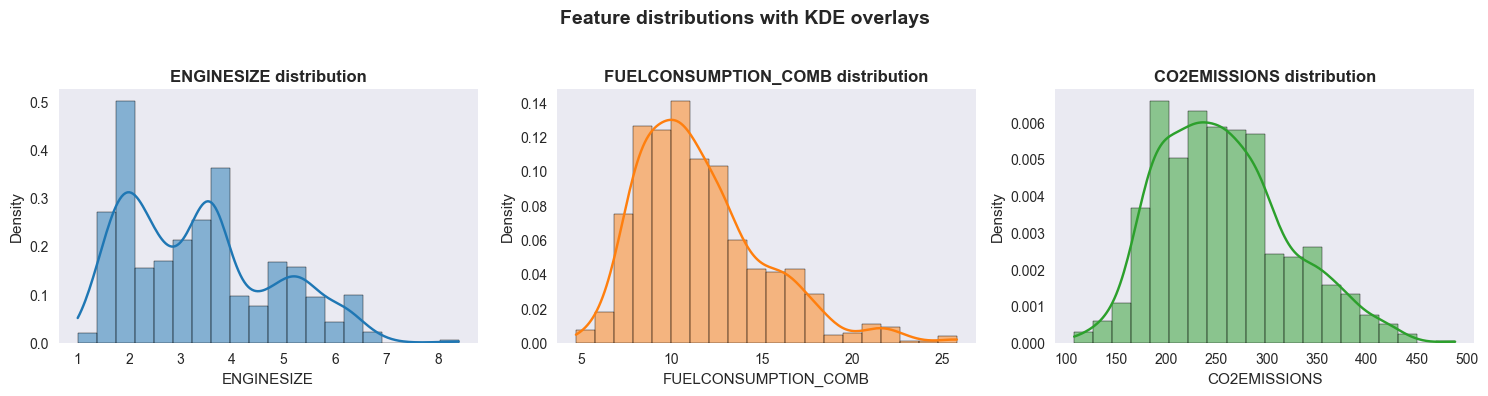

In [ ]:
"""
Vehicle Emission ML Regression Model
Author: Kashaf Fatima
Description: Multiple linear regression predicting CO2 emissions.
Includes EDA, scaling, regression, animated 2D regression line,
and interactive 3D regression plane visualization.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r"C:\Users\kashf\OneDrive\Desktop\Project 1\ffmpeg-7.1.1-essentials_build\bin\ffmpeg.exe"
from matplotlib.animation import FuncAnimation, FFMpegWriter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns
import os
import plotly.io as pio

pio.renderers.default = 'browser'  # Use browser renderer for interactive plotly plots

# Ensure assets folder exists
os.makedirs("assets", exist_ok=True)

plt.style.use('seaborn-v0_8')

def main():
    # Load data
    url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"
    df = pd.read_csv(url)
    df = df[['ENGINESIZE', 'FUELCONSUMPTION_COMB', 'CO2EMISSIONS']]

    print("Data sample:")
    print(df.sample(5))
    print("\nDataset shape:", df.shape)

    # EDA - Histograms with KDE
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    features = ['ENGINESIZE', 'FUELCONSUMPTION_COMB', 'CO2EMISSIONS']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, feature in enumerate(features):
        sns.histplot(df[feature], bins=20, kde=True, color=colors[i], ax=axes[i], edgecolor='black', stat="density")
        axes[i].set_title(f"{feature} distribution", fontsize=12, fontweight='bold')
        axes[i].grid(False)
        sns.despine(ax=axes[i])

    plt.suptitle("Feature distributions with KDE overlays", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig('assets/histograms.png')
    plt.show()
    input("Press Enter to continue...")  # Optional pause to keep window open

    # Prepare data
    X = df[['ENGINESIZE', 'FUELCONSUMPTION_COMB']].values
    y = df['CO2EMISSIONS'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train model
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    # Convert coefficients back to original scale
    means = scaler.mean_
    std_devs = np.sqrt(scaler.var_)
    coef_original = regressor.coef_ / std_devs
    intercept_original = regressor.intercept_ - np.sum((means * regressor.coef_) / std_devs)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    # Animated regression line
    X_engine_train = X_train[:, 0].reshape(-1, 1)
    reg_engine = LinearRegression().fit(X_engine_train, y_train)
    line_X = np.linspace(X_engine_train.min(), X_engine_train.max(), 200)
    line_y = reg_engine.coef_[0] * line_X + reg_engine.intercept_

    fig_anim, ax = plt.subplots(figsize=(7,5))
    ax.scatter(X_engine_train, y_train, color='#4C72B0', alpha=0.6, s=25, label="Training points")
    line_plot, = ax.plot([], [], color='#DD1C1A', lw=2, label="Regression line")
    ax.set_title("Animated: Regression line (Engine Size vs CO₂)")
    ax.legend()

    def init_anim():
        line_plot.set_data([], [])
        return (line_plot,)

    def animate(i):
        line_plot.set_data(line_X[:i], line_y[:i])
        return (line_plot,)

    ani = FuncAnimation(fig_anim, animate, frames=len(line_X), init_func=init_anim, interval=20, blit=True)

    # Save animation as MP4 (ffmpeg) and GIF
    writer = FFMpegWriter(fps=30, metadata=dict(artist='Kashaf Fatima'), bitrate=1800)
    ani.save('assets/vehicle_emission_animation.mp4', writer=writer)
    ani.save('assets/vehicle_emission_animation.gif', writer='pillow')
    plt.close(fig_anim)

    # Interactive 3D regression plane
    x1_range = np.linspace(X_test[:,0].min(), X_test[:,0].max(), 30)
    x2_range = np.linspace(X_test[:,1].min(), X_test[:,1].max(), 30)
    x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)
    y_mesh = regressor.intercept_ + regressor.coef_[0]*x1_mesh + regressor.coef_[1]*x2_mesh

    fig3d = go.Figure()
    fig3d.add_trace(go.Scatter3d(
        x=X_test[:,0], y=X_test[:,1], z=y_test,
        mode='markers',
        marker=dict(size=4, color=y_test, colorscale='Viridis', opacity=0.8),
        name="Actual (test)"
    ))
    fig3d.add_trace(go.Surface(
        x=x1_mesh, y=x2_mesh, z=y_mesh,
        colorscale='Viridis', opacity=0.6, showscale=False, name='Regression plane'
    ))
    fig3d.update_layout(
        title="Interactive 3D Regression Plane (scaled features)",
        scene=dict(
            xaxis_title='Engine Size (scaled)',
            yaxis_title='Fuel Consumption (scaled)',
            zaxis_title='CO₂ Emissions'
        ),
        width=900, height=600
    )

    fig3d.show()  # open interactive plot in browser

    input("Press Enter to continue...")  # pause to keep interactive window open

    # Save static image
    pio.write_image(fig3d, "assets/3d_regression_plane.png")

    print("\nFiles saved in 'assets' folder:")
    print("- histograms.png")
    print("- vehicle_emission_animation.mp4")
    print("- vehicle_emission_animation.gif")
    print("- 3d_regression_plane.png")

if __name__ == "__main__":
    main()